In [252]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import pandas as pd
import numpy as np


from funcs.helper import read_custom_aperture_lc, fetch_lightcurve
from funcs.multiperiod import show_flare, find_period

import time as Timestamp
from scipy import optimize

tstamp = Timestamp.strftime("%d_%m_%Y", time.localtime())

import emcee
import corner

In [253]:
CWD = "/".join(os.getcwd().split("/")[:-2])
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.370150,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.193000,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.351250,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.113000,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.190000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.132000,NaN,Zhan+19,UCAC4 116-015389,NaN
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,9.854,NaN,13.5570,10.8,0.7,0.378325,0.6844128,Kesseli+2018,NaN,NaN


In [254]:
lcs= lcs.loc[:5,]
lcs


,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.37015,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.19300,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.35125,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.11300,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.19000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.13200,NaN,Zhan+19,UCAC4 116-015389,NaN


In [474]:
def get_period_get_amplitude(target, plot=False, save=False, plotmini=False):
    """Fit a sinusoidal modulation and
    subtract it from the flux.

    Parameters:
    -----------
    target : Series
        Description of the target.
    plot : bool
        If True, will plot the periodogram
    save : bool
        If True, will save periodogram plot to file.

    Return:
    -------
    time, subtracted flux, model, period:
    array, array, array, astropy.Quantity
    """
    def cosine(x, a, b, c, d, e):
        """cosine with a linear trend"""
        return a * np.cos(b * x + c) + d * x + e

    # Fetch light curve
#     if target.origin=="custom":
    flck = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")
#     else: 
#         flck = flc

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False, custom=target.origin, flc=flck)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
#     if cut is not None:
#         cond = cond & (flck.time > cut[0]) & (flck.time < cut[1])
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])
    subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model
    print(target.ID, p)
    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    return period, rel_amplitude

In [475]:
campaigns = {237880881:[1,2],
             44984200: [8,9,10],
             277539431:[12],
             300741820:[1,2,4,5,6,7,8,9,10,11,12,13],
            }
res = pd.DataFrame(columns=["ID","QCS","rel_amplitude","period_h"])
for label, row in lcs.iterrows():
    if row.ID in campaigns.keys():
        for C in campaigns[row.ID]: 
            row.QCS = C
            print(row.QCS)
            period, relampl = get_period_get_amplitude(row)
            res = res.append(dict(zip(["ID","QCS","rel_amplitude","period_h"],
                                       [row.ID, C, abs(relampl),period.value])),ignore_index=True)

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


1
TIC 237880881 modulation period:  8.440140530163145 h
237880881 [-7.75192301e+00  1.78681079e+01 -1.55852265e+00  2.18150339e-02
  5.89294737e+02]
2
TIC 237880881 modulation period:  8.43155092474404 h
237880881 [-7.97574774e+00  1.78659283e+01  2.64977695e+01 -4.05869950e-03
  6.41593751e+02]
8
TIC 44984200 modulation period:  2.7113494815444104 h
44984200 [-6.37099832e+00  5.56126046e+01  6.43649000e+00 -5.24975756e+00
  9.22181443e+03]
9
TIC 44984200 modulation period:  2.7113734643352134 h
44984200 [-2.17111439e+00  5.56214524e+01 -7.29387452e+00 -1.49758472e+00
  2.77519632e+03]
10
TIC 44984200 modulation period:  2.7114843822240977 h
44984200 [ 8.25507467e+00  5.56007172e+01  2.17583380e+01 -2.49899814e+00
  5.64338931e+03]
12


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 277539431 modulation period:  4.556764823311947 h
277539431 [ 4.23320311e+00  3.30752837e+01  2.85623918e+01 -1.05034039e-01
  9.52266702e+02]
1
TIC 300741820 modulation period:  3.1669978996888606 h


7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (920/18684) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [-2.68664944e+00  4.75960032e+01  2.44733774e+01 -3.71946957e-05
  3.95270926e+02]
2
TIC 300741820 modulation period:  3.1680257192785115 h
300741820 [-2.80251080e+00  4.75932302e+01  9.37521264e+00 -2.84472342e-03
  4.08525334e+02]
4


6% (1050/18944) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
6% (1050/18944) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.167797039238444 h
300741820 [3.15341537e+00 4.75930396e+01 1.28289561e+01 4.78393684e-02
 3.35064205e+02]
5
TIC 300741820 modulation period:  3.1698679226439785 h


5% (843/15678) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (843/15678) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [ 3.37676343e+00  4.75942827e+01 -3.30307103e+01  9.51668773e-03
  4.18947498e+02]
6
TIC 300741820 modulation period:  3.167448431586461 h
300741820 [-3.40817318e+00  4.75878677e+01  2.98050581e+01 -5.05188577e-04
  4.15825297e+02]
7


11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.1681248249503158 h
300741820 [ 3.54855156e+00  4.75899416e+01  1.10763773e+01 -5.50011133e-03
  4.39778627e+02]
8
TIC 300741820 modulation period:  3.1686730172818667 h
300741820 [ 2.94801452e+00  4.75921192e+01 -4.70518237e+00 -1.27683224e-01
  6.01750187e+02]


5% (930/18187) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (930/18187) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


9
TIC 300741820 modulation period:  3.1698205935887716 h
300741820 [ 3.18754161e+00  4.75934091e+01 -3.18715123e+01 -1.60526157e-03
  4.15063410e+02]
10


5% (976/19527) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (976/19527) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.168882194542465 h
300741820 [-3.05632410e+00  4.75908917e+01 -5.87482884e+00 -1.05162632e-03
  4.20126392e+02]
11
TIC 300741820 modulation period:  3.169329826933344 h


5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


300741820 [-2.86763781e+00  4.75939108e+01 -2.32402085e+01  6.80403419e-03
  4.03793101e+02]
12
TIC 300741820 modulation period:  3.1690633176693517 h
300741820 [-2.91134522e+00  4.75979679e+01 -2.36117827e+01  1.96108809e-03
  4.10901054e+02]
13


4% (896/20479) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (896/20479) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.167791089691277 h
300741820 [-2.82131149e+00  4.75914133e+01  1.86263885e+01 -1.32581560e-03
  4.15129600e+02]


In [257]:
res

,ID,QCS,rel_amplitude,period_h
0,237880881.0,1.0,0.012565,8.440141
1,237880881.0,2.0,0.012542,8.431551
2,44984200.0,8.0,0.005242,2.711349
3,44984200.0,9.0,0.004885,2.711373
4,44984200.0,10.0,0.004895,2.711484
5,277539431.0,12.0,0.005433,4.556765
6,300741820.0,1.0,0.006799,3.166998
7,300741820.0,2.0,0.006925,3.168026
8,300741820.0,4.0,0.007822,3.167797
9,300741820.0,5.0,0.007803,3.169868


In [258]:
for i, g in res.groupby("ID"):
    print(i, g.rel_amplitude.mean(), g.rel_amplitude.std()/g.rel_amplitude.mean()*100)
    print(i, g.period_h.mean(), g.period_h.std()/g.period_h.mean()*100)

44984200.0 0.005007210887912111 4.055060354344716
44984200.0 2.7114024427012406 0.0026542630811061574
237880881.0 0.012553271108074231 0.13239634700357442
237880881.0 8.435845727453593 0.07199951772232983
277539431.0 0.005432627355323591 nan
277539431.0 4.556764823311947 nan
300741820.0 0.007402363204472216 7.176397896177508
300741820.0 3.1684851564244703 0.029359417206237873


In [259]:
(.004885 - .005242)/.004885

-0.073080859774821

## Fit period with MCMC


In [496]:
def cosine(x, a, b, c, d, e):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e


def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper


@logit
def uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate].

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    condition = ~(np.isfinite(maxrate) & np.isfinite(minrate))
    if ((maxrate < minrate) | condition):
        raise ValueError("maxrate must be > minrate, and a finite value")
    if ((rate >= minrate) & (rate <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0



def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp


def log_prior(p,):
    """Uniform prior

    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    

    prior = (uninformative_prior(p[0], 0.05, 1) +
             uninformative_prior(p[1], 0, 1e6) +
             uninformative_prior(p[2],  0, 1e6) +
             uninformative_prior(p[3], -1e6, 1e6)  +
             uninformative_prior(p[4], 0, 1e8) )

    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)




def log_likelihood(p, time, flux, flux_err):
    """Log likelihood function assuming
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON? No, because flux_err is not exactly sqrt(n), 
    and above several hundred counts
    """


    
    model = cosine(time, p[1], 2*np.pi/p[0], p[2],p[3],p[4])

    fr2 = flux_err**2
    val = -0.5 * np.sum((flux - model) ** 2 / fr2 + np.log(fr2))

        
    return val


def log_probability(p, time, flux, flux_err):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(p)

    if not np.isfinite(lp):
        print("INF")
        return -np.inf
    
    try:
        ll = log_likelihood(p, time, flux, flux_err)
        
    except:
        print("FAIL")
        return -np.inf
    
    if np.isnan(ll):
        print("NAN")
        return -np.inf
    
    return lp + ll

In [497]:
ID = 44984200

qcs = res.loc[res.ID == ID, "QCS"].values

target = lcs[lcs.ID ==ID].iloc[0]
target

ID                   44984200
QCS                        10
typ                       slc
cadence_min                 2
mission                  tess
prefix                    TIC
origin                 custom
h_mission                TESS
SpT                        M6
view_start            1587.25
view_stop             1589.75
view_min                 1620
view_max                 2200
BJDoff                2457000
tstart                1588.03
ampl_min                  0.5
ampl_max                  0.8
GRP                      1.54
plxmas                90.0357
eplxmas              0.222697
RA                    129.508
Dec                  -58.9331
J                      10.309
R                       15.08
Gaia_G                14.4115
vsini_kms                 NaN
e_vsini_kms               NaN
Prot_d                  0.113
sini                      NaN
Ref                 this work
identifier     SCR J0838-5855
Rstar                     NaN
Name: 3, dtype: object

In [498]:
times, fluxes, flux_errs = [], [], []
# for QCS in qcs:
#     target.QCS = int(QCS)#str(int(QCS)).zfill(2)
#     print(target.QCS)
#     print(f"{target.QCS:02d}")
flcd = fetch_lightcurve(target, flux_type="PDCSAP_FLUX")

flcd.flux[((flcd.time > 1587.) & (flcd.time < 1589.5))] = np.nan
flcd = flcd[np.where(np.isfinite(flcd.flux))]
flcd = flcd.flatten(window_length=1001)
time = flcd.time
flux = flcd.flux
flux_err = flcd.flux_err
    

In [499]:
time, flux, flux_err

(array([1571.12528444, 1571.12667332, 1571.1280622 , ..., 1595.67913614,
        1595.680525  , 1595.68191386]),
 array([0.99223181, 1.00418947, 0.99206594, ..., 0.99737109, 1.01067759,
        0.99731047]),
 array([0.00620844, 0.00620592, 0.00619882, ..., 0.00572901, 0.00575479,
        0.00575891]))

In [500]:
perd = res.loc[res.ID == ID, "period_h"].mean() / 24.
relampl = res.loc[res.ID == ID, "rel_amplitude"].mean()
meanflux = np.nanmedian(flux)

In [501]:
inits = [perd, relampl*meanflux, 6.4,  1e-8, np.nanmedian(flux)]

In [502]:
pos = inits * (1. + 1e-4 * np.random.randn(32, len(inits)))

In [503]:
inits

[0.11297510177921836, 0.00500718490306461, 6.4, 1e-08, 0.9999948105146592]

In [504]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/rotation/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(32, len(inits))
args = (time, flux, flux_err)

sampler = emcee.EnsembleSampler(32, len(inits), log_probability,
                                args=args,backend=backend)

In [505]:
start = Timestamp.time()
sampler.run_mcmc(pos, 1000, progress=True, store=True)
end = Timestamp.time()
multi_data_time = end - start
print("MCMC took {0:.1f} seconds".format(multi_data_time))

 50%|█████     | 503/1000 [00:12<00:12, 39.47it/s]

INF
INF


 55%|█████▍    | 545/1000 [00:13<00:11, 40.28it/s]

INF
INF


 56%|█████▌    | 555/1000 [00:13<00:11, 38.43it/s]

INF
INF
INF
INF


 56%|█████▋    | 563/1000 [00:14<00:11, 39.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 573/1000 [00:14<00:10, 40.41it/s]

INF
INF
INF
INF
INF


 58%|█████▊    | 583/1000 [00:14<00:10, 41.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 593/1000 [00:14<00:10, 39.98it/s]

INF
INF
INF
INF


 61%|██████    | 608/1000 [00:15<00:09, 41.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 613/1000 [00:15<00:09, 41.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 623/1000 [00:15<00:09, 41.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 633/1000 [00:15<00:09, 40.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 638/1000 [00:15<00:09, 39.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 647/1000 [00:16<00:08, 40.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 657/1000 [00:16<00:08, 41.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 667/1000 [00:16<00:07, 42.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 672/1000 [00:16<00:07, 41.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 682/1000 [00:16<00:07, 41.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 692/1000 [00:17<00:07, 42.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 702/1000 [00:17<00:07, 42.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 712/1000 [00:17<00:06, 41.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 717/1000 [00:17<00:06, 41.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 727/1000 [00:17<00:06, 42.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 737/1000 [00:18<00:06, 42.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 747/1000 [00:18<00:05, 42.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 757/1000 [00:18<00:05, 42.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 762/1000 [00:18<00:05, 41.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 772/1000 [00:19<00:05, 41.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 781/1000 [00:19<00:05, 37.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 790/1000 [00:19<00:05, 39.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 800/1000 [00:19<00:05, 39.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 810/1000 [00:20<00:04, 41.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 815/1000 [00:20<00:04, 41.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▎ | 825/1000 [00:20<00:04, 42.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 835/1000 [00:20<00:03, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 840/1000 [00:20<00:03, 43.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 850/1000 [00:20<00:03, 39.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 860/1000 [00:21<00:03, 40.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 870/1000 [00:21<00:03, 42.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 875/1000 [00:21<00:02, 42.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 885/1000 [00:21<00:02, 42.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 895/1000 [00:22<00:02, 42.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 905/1000 [00:22<00:02, 43.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 910/1000 [00:22<00:02, 42.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 920/1000 [00:22<00:01, 43.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 930/1000 [00:22<00:01, 42.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 940/1000 [00:23<00:01, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 950/1000 [00:23<00:01, 42.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 960/1000 [00:23<00:00, 43.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 965/1000 [00:23<00:00, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 975/1000 [00:23<00:00, 43.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 985/1000 [00:24<00:00, 43.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 995/1000 [00:24<00:00, 43.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 1000/1000 [00:24<00:00, 40.86it/s]

INF
INF
INF
INF
INF
INF
MCMC took 24.5 seconds


In [514]:
sampler.run_mcmc(None, 13000, progress=True, store=True)

  0%|          | 4/13000 [00:00<06:20, 34.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 14/13000 [00:00<05:47, 37.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 24/13000 [00:00<05:24, 40.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 34/13000 [00:00<05:08, 42.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 39/13000 [00:00<05:03, 42.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 49/13000 [00:01<05:01, 42.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  0%|          | 59/13000 [00:01<05:00, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 69/13000 [00:01<04:58, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 74/13000 [00:01<04:55, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 84/13000 [00:01<04:52, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 94/13000 [00:02<04:54, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 104/13000 [00:02<04:57, 43.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 114/13000 [00:02<04:52, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 119/13000 [00:02<04:52, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 129/13000 [00:02<04:49, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 139/13000 [00:03<04:54, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 149/13000 [00:03<04:49, 44.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|          | 159/13000 [00:03<04:49, 44.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|▏         | 164/13000 [00:03<04:47, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|▏         | 174/13000 [00:04<05:07, 41.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|▏         | 184/13000 [00:04<05:01, 42.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  1%|▏         | 194/13000 [00:04<04:59, 42.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 204/13000 [00:04<04:59, 42.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 209/13000 [00:04<04:53, 43.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 219/13000 [00:05<04:53, 43.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 229/13000 [00:05<04:49, 44.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 239/13000 [00:05<04:42, 45.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 249/13000 [00:05<04:41, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 254/13000 [00:05<04:47, 44.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 264/13000 [00:06<04:49, 44.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 274/13000 [00:06<04:47, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 284/13000 [00:06<04:47, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 294/13000 [00:06<04:42, 44.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 304/13000 [00:06<04:42, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 314/13000 [00:07<04:47, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  2%|▏         | 319/13000 [00:07<04:49, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 329/13000 [00:07<04:43, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 339/13000 [00:07<04:41, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 349/13000 [00:07<04:36, 45.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 359/13000 [00:08<04:36, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 369/13000 [00:08<04:36, 45.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 379/13000 [00:08<04:40, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 389/13000 [00:08<04:38, 45.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 394/13000 [00:08<04:37, 45.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 404/13000 [00:09<04:39, 45.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 414/13000 [00:09<04:43, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 424/13000 [00:09<04:39, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 434/13000 [00:09<04:34, 45.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 444/13000 [00:10<04:36, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  3%|▎         | 454/13000 [00:10<04:38, 44.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 459/13000 [00:10<04:40, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 469/13000 [00:10<04:39, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▎         | 479/13000 [00:10<04:38, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 489/13000 [00:11<04:43, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 499/13000 [00:11<04:42, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 509/13000 [00:11<04:37, 44.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 519/13000 [00:11<04:39, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 524/13000 [00:11<04:39, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 534/13000 [00:12<04:41, 44.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 544/13000 [00:12<04:38, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 554/13000 [00:12<04:34, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 564/13000 [00:12<04:28, 46.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 574/13000 [00:12<04:35, 45.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  4%|▍         | 579/13000 [00:13<04:42, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 589/13000 [00:13<04:38, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 599/13000 [00:13<04:30, 45.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 609/13000 [00:13<04:35, 45.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 619/13000 [00:13<04:36, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 629/13000 [00:14<04:33, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 639/13000 [00:14<04:29, 45.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▍         | 649/13000 [00:14<04:33, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 654/13000 [00:14<04:32, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 664/13000 [00:14<04:31, 45.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 674/13000 [00:15<04:32, 45.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 684/13000 [00:15<04:32, 45.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 694/13000 [00:15<04:28, 45.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 704/13000 [00:15<04:30, 45.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  5%|▌         | 714/13000 [00:16<04:32, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 724/13000 [00:16<04:36, 44.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 729/13000 [00:16<04:35, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 739/13000 [00:16<04:34, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 749/13000 [00:16<04:35, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 759/13000 [00:17<04:38, 43.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 769/13000 [00:17<04:41, 43.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 774/13000 [00:17<04:48, 42.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 784/13000 [00:17<04:42, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 794/13000 [00:17<04:40, 43.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▌         | 804/13000 [00:18<04:45, 42.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 814/13000 [00:18<04:40, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 819/13000 [00:18<04:38, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 829/13000 [00:18<04:35, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  6%|▋         | 839/13000 [00:18<04:29, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 849/13000 [00:19<04:32, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 859/13000 [00:19<04:30, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 869/13000 [00:19<04:26, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 879/13000 [00:19<04:22, 46.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 889/13000 [00:20<04:27, 45.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 894/13000 [00:20<04:33, 44.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 904/13000 [00:20<04:30, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 914/13000 [00:20<04:32, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 924/13000 [00:20<04:29, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 929/13000 [00:20<04:32, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 939/13000 [00:21<04:37, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 949/13000 [00:21<04:32, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 959/13000 [00:21<04:34, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  7%|▋         | 969/13000 [00:21<04:28, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 979/13000 [00:22<04:27, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 984/13000 [00:22<04:29, 44.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 994/13000 [00:22<04:33, 43.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1004/13000 [00:22<04:22, 45.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1014/13000 [00:22<04:19, 46.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1024/13000 [00:23<04:19, 46.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1034/13000 [00:23<04:27, 44.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1044/13000 [00:23<04:21, 45.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1054/13000 [00:23<04:22, 45.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1064/13000 [00:23<04:20, 45.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1069/13000 [00:24<04:24, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1079/13000 [00:24<04:25, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1089/13000 [00:24<04:22, 45.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  8%|▊         | 1099/13000 [00:24<04:21, 45.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▊         | 1109/13000 [00:24<04:21, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▊         | 1119/13000 [00:25<04:20, 45.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▊         | 1129/13000 [00:25<04:18, 45.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1139/13000 [00:25<04:16, 46.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1144/13000 [00:25<04:16, 46.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1154/13000 [00:25<04:20, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1164/13000 [00:26<04:26, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1174/13000 [00:26<04:21, 45.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1184/13000 [00:26<04:17, 45.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1194/13000 [00:26<04:19, 45.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1199/13000 [00:26<04:18, 45.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1209/13000 [00:27<04:19, 45.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1219/13000 [00:27<04:19, 45.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


  9%|▉         | 1229/13000 [00:27<04:13, 46.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1239/13000 [00:27<04:15, 46.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1249/13000 [00:27<04:13, 46.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1259/13000 [00:28<04:24, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1264/13000 [00:28<04:22, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1274/13000 [00:28<04:18, 45.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1284/13000 [00:28<04:10, 46.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|▉         | 1294/13000 [00:28<04:09, 46.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1304/13000 [00:29<04:13, 46.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1314/13000 [00:29<04:15, 45.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1324/13000 [00:29<04:13, 46.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1334/13000 [00:29<04:12, 46.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1344/13000 [00:30<04:11, 46.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1354/13000 [00:30<04:17, 45.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 10%|█         | 1359/13000 [00:30<04:16, 45.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1369/13000 [00:30<04:15, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1379/13000 [00:30<04:12, 46.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1389/13000 [00:31<04:08, 46.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1399/13000 [00:31<04:12, 45.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1409/13000 [00:31<04:13, 45.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1419/13000 [00:31<04:14, 45.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1429/13000 [00:31<04:13, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1434/13000 [00:32<04:13, 45.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1444/13000 [00:32<04:20, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█         | 1454/13000 [00:32<04:12, 45.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 1464/13000 [00:32<04:07, 46.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 1474/13000 [00:32<04:07, 46.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 1484/13000 [00:33<04:10, 46.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 11%|█▏        | 1494/13000 [00:33<04:09, 46.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1504/13000 [00:33<04:10, 45.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1514/13000 [00:33<04:12, 45.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1524/13000 [00:34<04:11, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1534/13000 [00:34<04:11, 45.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1544/13000 [00:34<04:09, 45.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1549/13000 [00:34<04:08, 46.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1559/13000 [00:34<04:09, 45.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1569/13000 [00:34<04:08, 45.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1579/13000 [00:35<04:10, 45.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1589/13000 [00:35<04:09, 45.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1599/13000 [00:35<04:07, 45.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1609/13000 [00:35<04:09, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1619/13000 [00:36<04:19, 43.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 12%|█▏        | 1624/13000 [00:36<04:17, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1634/13000 [00:36<04:14, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1644/13000 [00:36<04:16, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1654/13000 [00:36<04:13, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1659/13000 [00:37<04:21, 43.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1669/13000 [00:37<04:23, 43.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1679/13000 [00:37<04:15, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1689/13000 [00:37<04:11, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1699/13000 [00:37<04:11, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1709/13000 [00:38<04:13, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1719/13000 [00:38<04:12, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1724/13000 [00:38<04:11, 44.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1734/13000 [00:38<04:13, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1744/13000 [00:38<04:14, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 13%|█▎        | 1754/13000 [00:39<04:14, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 1764/13000 [00:39<04:17, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 1769/13000 [00:39<04:16, 43.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▎        | 1779/13000 [00:39<04:11, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1789/13000 [00:39<04:13, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1799/13000 [00:40<04:10, 44.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1809/13000 [00:40<04:09, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1819/13000 [00:40<04:07, 45.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1824/13000 [00:40<04:07, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1834/13000 [00:40<04:08, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1844/13000 [00:41<04:07, 44.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1854/13000 [00:41<04:11, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1864/13000 [00:41<04:10, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1874/13000 [00:41<04:10, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 14%|█▍        | 1884/13000 [00:42<04:06, 45.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1889/13000 [00:42<04:14, 43.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1899/13000 [00:42<04:09, 44.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1909/13000 [00:42<04:03, 45.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1919/13000 [00:42<04:03, 45.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1929/13000 [00:43<04:04, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1939/13000 [00:43<04:07, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▍        | 1944/13000 [00:43<04:06, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 1954/13000 [00:43<04:01, 45.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 1964/13000 [00:43<04:04, 45.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 1974/13000 [00:44<04:06, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 1984/13000 [00:44<04:05, 44.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 1994/13000 [00:44<04:03, 45.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 2004/13000 [00:44<04:01, 45.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 15%|█▌        | 2014/13000 [00:44<04:01, 45.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2019/13000 [00:45<04:03, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2029/13000 [00:45<04:05, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2039/13000 [00:45<04:13, 43.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2049/13000 [00:45<04:09, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2059/13000 [00:45<04:09, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2064/13000 [00:46<04:15, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2074/13000 [00:46<04:11, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2084/13000 [00:46<04:05, 44.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2094/13000 [00:46<04:03, 44.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▌        | 2104/13000 [00:46<04:01, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▋        | 2114/13000 [00:47<03:58, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▋        | 2119/13000 [00:47<04:01, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▋        | 2129/13000 [00:47<04:01, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 16%|█▋        | 2139/13000 [00:47<04:02, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2149/13000 [00:47<03:59, 45.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2159/13000 [00:48<04:06, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2169/13000 [00:48<04:04, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2174/13000 [00:48<04:12, 42.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2184/13000 [00:48<04:09, 43.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2194/13000 [00:49<04:02, 44.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2204/13000 [00:49<04:04, 44.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2214/13000 [00:49<03:58, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2224/13000 [00:49<03:58, 45.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2234/13000 [00:49<03:59, 44.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2239/13000 [00:50<04:00, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2249/13000 [00:50<04:03, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2259/13000 [00:50<04:03, 44.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 17%|█▋        | 2269/13000 [00:50<03:58, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2279/13000 [00:50<03:59, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2284/13000 [00:51<03:58, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2294/13000 [00:51<04:05, 43.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2304/13000 [00:51<03:59, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2314/13000 [00:51<03:57, 45.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2324/13000 [00:51<03:55, 45.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2334/13000 [00:52<03:57, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2344/13000 [00:52<03:55, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2354/13000 [00:52<03:55, 45.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2359/13000 [00:52<04:01, 44.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2369/13000 [00:52<04:00, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2379/13000 [00:53<04:07, 42.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2389/13000 [00:53<04:02, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2399/13000 [00:53<03:59, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 18%|█▊        | 2404/13000 [00:53<03:57, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▊        | 2414/13000 [00:53<03:54, 45.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▊        | 2424/13000 [00:54<03:57, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▊        | 2434/13000 [00:54<03:56, 44.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2444/13000 [00:54<03:54, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2454/13000 [00:54<03:51, 45.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2464/13000 [00:55<03:54, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2469/13000 [00:55<03:57, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2479/13000 [00:55<03:54, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2489/13000 [00:55<03:59, 43.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2499/13000 [00:55<03:55, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2509/13000 [00:56<03:59, 43.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2514/13000 [00:56<03:59, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2524/13000 [00:56<03:59, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 19%|█▉        | 2534/13000 [00:56<03:53, 44.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2544/13000 [00:56<03:55, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2554/13000 [00:57<03:57, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2564/13000 [00:57<03:56, 44.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2574/13000 [00:57<03:55, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2584/13000 [00:57<03:54, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2589/13000 [00:57<03:56, 44.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|█▉        | 2599/13000 [00:58<03:57, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2609/13000 [00:58<03:56, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2619/13000 [00:58<03:56, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2629/13000 [00:58<03:52, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2639/13000 [00:59<03:51, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2644/13000 [00:59<03:54, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2654/13000 [00:59<03:59, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 20%|██        | 2664/13000 [00:59<03:53, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2674/13000 [00:59<03:51, 44.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2684/13000 [01:00<03:52, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2689/13000 [01:00<03:55, 43.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2699/13000 [01:00<03:55, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2709/13000 [01:00<03:55, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2719/13000 [01:00<03:53, 44.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2729/13000 [01:01<03:50, 44.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2739/13000 [01:01<03:52, 44.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2744/13000 [01:01<03:51, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██        | 2754/13000 [01:01<03:55, 43.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 2764/13000 [01:01<03:52, 44.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 2774/13000 [01:02<03:57, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 2784/13000 [01:02<03:52, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 21%|██▏       | 2794/13000 [01:02<03:49, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2799/13000 [01:02<03:49, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2809/13000 [01:02<03:49, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2819/13000 [01:03<03:50, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2829/13000 [01:03<03:45, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2839/13000 [01:03<03:46, 44.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2849/13000 [01:03<03:46, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2854/13000 [01:03<03:45, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2864/13000 [01:04<03:52, 43.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2874/13000 [01:04<03:48, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2884/13000 [01:04<03:46, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2894/13000 [01:04<03:42, 45.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2899/13000 [01:04<03:46, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2909/13000 [01:05<03:53, 43.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 22%|██▏       | 2919/13000 [01:05<04:02, 41.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2929/13000 [01:05<03:54, 42.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2939/13000 [01:05<03:51, 43.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2944/13000 [01:05<03:50, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2954/13000 [01:06<03:50, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2964/13000 [01:06<03:48, 43.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2974/13000 [01:06<03:45, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2984/13000 [01:06<03:43, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2989/13000 [01:06<03:48, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 2999/13000 [01:07<03:43, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3009/13000 [01:07<03:45, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3019/13000 [01:07<03:42, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3029/13000 [01:07<03:42, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3039/13000 [01:08<03:46, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3044/13000 [01:08<03:48, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 23%|██▎       | 3054/13000 [01:08<03:46, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▎       | 3064/13000 [01:08<03:44, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▎       | 3074/13000 [01:08<03:44, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▎       | 3084/13000 [01:09<03:50, 42.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3089/13000 [01:09<03:46, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3099/13000 [01:09<03:43, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3109/13000 [01:09<03:40, 44.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3119/13000 [01:09<03:39, 45.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3129/13000 [01:10<03:46, 43.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3139/13000 [01:10<03:43, 44.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3149/13000 [01:10<03:39, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3159/13000 [01:10<03:38, 45.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3164/13000 [01:10<03:37, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3174/13000 [01:11<03:42, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 24%|██▍       | 3184/13000 [01:11<03:40, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3194/13000 [01:11<03:41, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3204/13000 [01:11<03:42, 43.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3209/13000 [01:11<03:43, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3219/13000 [01:12<03:48, 42.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3229/13000 [01:12<03:55, 41.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3239/13000 [01:12<03:46, 43.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▍       | 3249/13000 [01:12<03:38, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3254/13000 [01:12<03:35, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3264/13000 [01:13<03:40, 44.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3274/13000 [01:13<03:39, 44.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3284/13000 [01:13<03:36, 44.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3294/13000 [01:13<03:33, 45.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3304/13000 [01:14<03:33, 45.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 25%|██▌       | 3314/13000 [01:14<03:37, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3319/13000 [01:14<03:37, 44.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3329/13000 [01:14<03:31, 45.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3339/13000 [01:14<03:30, 45.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3349/13000 [01:15<03:46, 42.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3359/13000 [01:15<03:40, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3369/13000 [01:15<03:33, 45.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3374/13000 [01:15<03:33, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3384/13000 [01:15<03:33, 44.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3394/13000 [01:16<03:34, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▌       | 3404/13000 [01:16<03:32, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 3414/13000 [01:16<03:33, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 3424/13000 [01:16<03:32, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 3434/13000 [01:16<03:30, 45.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 26%|██▋       | 3439/13000 [01:17<03:32, 45.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3449/13000 [01:17<03:36, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3459/13000 [01:17<03:35, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3469/13000 [01:17<03:33, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3479/13000 [01:18<03:32, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3484/13000 [01:18<03:41, 42.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3494/13000 [01:18<03:38, 43.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3504/13000 [01:18<03:35, 44.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3514/13000 [01:18<03:31, 44.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3524/13000 [01:19<03:32, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3534/13000 [01:19<03:36, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3544/13000 [01:19<03:31, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3549/13000 [01:19<03:30, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3559/13000 [01:19<03:32, 44.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 27%|██▋       | 3569/13000 [01:20<03:28, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3579/13000 [01:20<03:30, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3589/13000 [01:20<03:27, 45.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3599/13000 [01:20<03:26, 45.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3604/13000 [01:20<03:28, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3614/13000 [01:21<03:26, 45.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3624/13000 [01:21<03:29, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3634/13000 [01:21<03:29, 44.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3644/13000 [01:21<03:30, 44.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3654/13000 [01:21<03:31, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3659/13000 [01:22<03:30, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3669/13000 [01:22<03:32, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3679/13000 [01:22<03:26, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3689/13000 [01:22<03:25, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 28%|██▊       | 3699/13000 [01:22<03:24, 45.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 3709/13000 [01:23<03:29, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 3719/13000 [01:23<03:27, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▊       | 3729/13000 [01:23<03:25, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3739/13000 [01:23<03:26, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3744/13000 [01:23<03:28, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3754/13000 [01:24<03:30, 43.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3764/13000 [01:24<03:28, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3774/13000 [01:24<03:29, 44.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3784/13000 [01:24<03:27, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3794/13000 [01:25<03:22, 45.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3804/13000 [01:25<03:23, 45.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3809/13000 [01:25<03:23, 45.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3819/13000 [01:25<03:23, 45.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 29%|██▉       | 3829/13000 [01:25<03:20, 45.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3839/13000 [01:26<03:24, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3849/13000 [01:26<03:28, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3859/13000 [01:26<03:24, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3864/13000 [01:26<03:23, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3874/13000 [01:26<03:21, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3884/13000 [01:27<03:22, 44.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|██▉       | 3894/13000 [01:27<03:25, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3904/13000 [01:27<03:24, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3914/13000 [01:27<03:22, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3924/13000 [01:27<03:19, 45.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3929/13000 [01:28<03:28, 43.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3939/13000 [01:28<03:24, 44.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3949/13000 [01:28<03:19, 45.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 30%|███       | 3959/13000 [01:28<03:20, 45.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 3969/13000 [01:28<03:17, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 3979/13000 [01:29<03:19, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 3989/13000 [01:29<03:18, 45.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 3999/13000 [01:29<03:18, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4009/13000 [01:29<03:18, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4019/13000 [01:30<03:18, 45.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4029/13000 [01:30<03:20, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4034/13000 [01:30<03:20, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4044/13000 [01:30<03:18, 45.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███       | 4054/13000 [01:30<03:17, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███▏      | 4064/13000 [01:31<03:19, 44.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███▏      | 4074/13000 [01:31<03:18, 45.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███▏      | 4084/13000 [01:31<03:20, 44.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 31%|███▏      | 4094/13000 [01:31<03:19, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4099/13000 [01:31<03:16, 45.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4109/13000 [01:32<03:24, 43.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4119/13000 [01:32<03:25, 43.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4129/13000 [01:32<03:20, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4139/13000 [01:32<03:15, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4149/13000 [01:32<03:14, 45.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4154/13000 [01:33<03:16, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4164/13000 [01:33<03:18, 44.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4174/13000 [01:33<03:15, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4184/13000 [01:33<03:13, 45.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4194/13000 [01:33<03:14, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4204/13000 [01:34<03:17, 44.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4214/13000 [01:34<03:17, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 32%|███▏      | 4224/13000 [01:34<03:15, 44.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4229/13000 [01:34<03:13, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4239/13000 [01:34<03:10, 46.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4249/13000 [01:35<03:13, 45.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4259/13000 [01:35<03:14, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4269/13000 [01:35<03:12, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4279/13000 [01:35<03:09, 45.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4284/13000 [01:35<03:08, 46.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4294/13000 [01:36<03:17, 44.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4304/13000 [01:36<03:15, 44.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4314/13000 [01:36<03:12, 45.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4324/13000 [01:36<03:10, 45.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4334/13000 [01:37<03:10, 45.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4344/13000 [01:37<03:11, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 33%|███▎      | 4354/13000 [01:37<03:10, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 4359/13000 [01:37<03:08, 45.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 4369/13000 [01:37<03:09, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▎      | 4379/13000 [01:38<03:07, 45.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4389/13000 [01:38<03:10, 45.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4399/13000 [01:38<03:11, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4409/13000 [01:38<03:07, 45.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4419/13000 [01:38<03:05, 46.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4429/13000 [01:39<03:12, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4434/13000 [01:39<03:13, 44.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4444/13000 [01:39<03:09, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4454/13000 [01:39<03:09, 45.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4464/13000 [01:39<03:09, 45.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4474/13000 [01:40<03:10, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 34%|███▍      | 4484/13000 [01:40<03:08, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4494/13000 [01:40<03:07, 45.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4504/13000 [01:40<03:04, 45.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4514/13000 [01:41<03:06, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4519/13000 [01:41<03:08, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4529/13000 [01:41<03:09, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4539/13000 [01:41<03:07, 45.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▍      | 4549/13000 [01:41<03:05, 45.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4559/13000 [01:42<03:07, 44.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4569/13000 [01:42<03:10, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4579/13000 [01:42<03:10, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4584/13000 [01:42<03:07, 44.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4594/13000 [01:42<03:07, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4604/13000 [01:43<03:07, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 35%|███▌      | 4614/13000 [01:43<03:07, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4624/13000 [01:43<03:09, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4634/13000 [01:43<03:08, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4639/13000 [01:43<03:08, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4649/13000 [01:44<03:07, 44.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4659/13000 [01:44<03:10, 43.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4669/13000 [01:44<03:09, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4679/13000 [01:44<03:08, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4689/13000 [01:44<03:08, 44.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4694/13000 [01:45<03:09, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▌      | 4704/13000 [01:45<03:08, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 4714/13000 [01:45<03:09, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 4724/13000 [01:45<03:05, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 4734/13000 [01:46<03:07, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 36%|███▋      | 4744/13000 [01:46<03:11, 43.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4749/13000 [01:46<03:11, 43.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4759/13000 [01:46<03:06, 44.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4769/13000 [01:46<03:04, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4779/13000 [01:47<03:05, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4789/13000 [01:47<03:01, 45.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4799/13000 [01:47<03:03, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4809/13000 [01:47<03:02, 44.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4814/13000 [01:47<03:02, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4824/13000 [01:48<03:03, 44.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4834/13000 [01:48<03:05, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4844/13000 [01:48<03:04, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4854/13000 [01:48<03:02, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4859/13000 [01:48<03:02, 44.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 37%|███▋      | 4869/13000 [01:49<03:02, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4879/13000 [01:49<03:02, 44.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4889/13000 [01:49<02:59, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4899/13000 [01:49<02:58, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4909/13000 [01:49<03:01, 44.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4914/13000 [01:50<03:01, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4924/13000 [01:50<03:04, 43.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4934/13000 [01:50<02:58, 45.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4944/13000 [01:50<02:57, 45.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4954/13000 [01:50<02:57, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4964/13000 [01:51<03:00, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4974/13000 [01:51<02:56, 45.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4979/13000 [01:51<02:57, 45.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4989/13000 [01:51<02:57, 45.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 38%|███▊      | 4999/13000 [01:51<02:58, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 5009/13000 [01:52<03:06, 42.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 5019/13000 [01:52<03:03, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 5024/13000 [01:52<03:02, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▊      | 5034/13000 [01:52<02:59, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5044/13000 [01:52<03:03, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5054/13000 [01:53<03:00, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5064/13000 [01:53<02:59, 44.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5074/13000 [01:53<02:56, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5079/13000 [01:53<02:55, 45.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5089/13000 [01:53<02:57, 44.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5099/13000 [01:54<02:57, 44.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5109/13000 [01:54<02:59, 43.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5119/13000 [01:54<02:55, 44.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5129/13000 [01:54<02:53, 45.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 39%|███▉      | 5134/13000 [01:55<02:54, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5144/13000 [01:55<02:57, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5154/13000 [01:55<02:54, 44.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5164/13000 [01:55<02:52, 45.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5174/13000 [01:55<02:51, 45.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5184/13000 [01:56<02:55, 44.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|███▉      | 5194/13000 [01:56<02:54, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5204/13000 [01:56<02:53, 44.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5209/13000 [01:56<02:53, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5219/13000 [01:56<02:53, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5229/13000 [01:57<02:55, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5239/13000 [01:57<02:54, 44.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5249/13000 [01:57<02:53, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 40%|████      | 5259/13000 [01:57<02:52, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5269/13000 [01:58<02:50, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5274/13000 [01:58<02:52, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5284/13000 [01:58<02:54, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5294/13000 [01:58<02:52, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5304/13000 [01:58<02:49, 45.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5314/13000 [01:59<02:48, 45.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5324/13000 [01:59<02:54, 44.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5329/13000 [01:59<02:57, 43.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5339/13000 [01:59<02:53, 44.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5349/13000 [01:59<02:54, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████      | 5359/13000 [02:00<02:51, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████▏     | 5369/13000 [02:00<02:53, 43.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████▏     | 5379/13000 [02:00<02:51, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████▏     | 5384/13000 [02:00<02:52, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 41%|████▏     | 5394/13000 [02:00<02:52, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5404/13000 [02:01<02:52, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5414/13000 [02:01<02:56, 43.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5424/13000 [02:01<02:53, 43.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5429/13000 [02:01<02:53, 43.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5439/13000 [02:01<02:51, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5449/13000 [02:02<02:50, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5459/13000 [02:02<02:53, 43.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5469/13000 [02:02<02:47, 45.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5474/13000 [02:02<02:47, 44.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5484/13000 [02:02<02:46, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5494/13000 [02:03<02:45, 45.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5504/13000 [02:03<02:47, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5514/13000 [02:03<02:46, 45.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 42%|████▏     | 5524/13000 [02:03<02:45, 45.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5534/13000 [02:03<02:46, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5539/13000 [02:04<02:50, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5549/13000 [02:04<02:50, 43.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5559/13000 [02:04<02:49, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5569/13000 [02:04<02:47, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5579/13000 [02:05<02:45, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5589/13000 [02:05<02:44, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5599/13000 [02:05<02:45, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5609/13000 [02:05<02:45, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5614/13000 [02:05<02:46, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5624/13000 [02:06<02:45, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5634/13000 [02:06<02:46, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5644/13000 [02:06<02:44, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 43%|████▎     | 5654/13000 [02:06<02:45, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 5659/13000 [02:06<02:47, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 5669/13000 [02:07<02:46, 44.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▎     | 5679/13000 [02:07<02:45, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5689/13000 [02:07<02:46, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5699/13000 [02:07<02:43, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5709/13000 [02:07<02:42, 44.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5714/13000 [02:08<02:41, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5724/13000 [02:08<02:43, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5734/13000 [02:08<02:41, 45.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5744/13000 [02:08<02:40, 45.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5754/13000 [02:08<02:40, 45.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5764/13000 [02:09<02:44, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5769/13000 [02:09<02:44, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 44%|████▍     | 5779/13000 [02:09<02:42, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5789/13000 [02:09<02:40, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5799/13000 [02:09<02:42, 44.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5809/13000 [02:10<02:44, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5819/13000 [02:10<02:40, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5824/13000 [02:10<02:39, 44.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5834/13000 [02:10<02:39, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▍     | 5844/13000 [02:10<02:36, 45.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5854/13000 [02:11<02:39, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5864/13000 [02:11<02:42, 44.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5874/13000 [02:11<02:41, 44.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5884/13000 [02:11<02:39, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5889/13000 [02:11<02:39, 44.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5899/13000 [02:12<02:42, 43.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 45%|████▌     | 5909/13000 [02:12<02:41, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5919/13000 [02:12<02:41, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5929/13000 [02:12<02:41, 43.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5934/13000 [02:12<02:40, 43.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5944/13000 [02:13<02:42, 43.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5954/13000 [02:13<02:43, 43.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5964/13000 [02:13<02:41, 43.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5974/13000 [02:13<02:41, 43.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5984/13000 [02:14<02:42, 43.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5989/13000 [02:14<02:39, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 5999/13000 [02:14<02:37, 44.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▌     | 6009/13000 [02:14<02:36, 44.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 6019/13000 [02:14<02:39, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 6024/13000 [02:15<02:39, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 6034/13000 [02:15<02:49, 41.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 46%|████▋     | 6044/13000 [02:15<02:45, 42.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6054/13000 [02:15<02:40, 43.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6064/13000 [02:16<02:38, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6069/13000 [02:16<02:39, 43.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6079/13000 [02:16<02:37, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6089/13000 [02:16<02:35, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6099/13000 [02:16<02:32, 45.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6109/13000 [02:17<02:33, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6119/13000 [02:17<02:35, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6129/13000 [02:17<02:33, 44.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6134/13000 [02:17<02:32, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6144/13000 [02:17<02:32, 45.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6154/13000 [02:18<02:29, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6164/13000 [02:18<02:32, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 47%|████▋     | 6174/13000 [02:18<02:30, 45.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6184/13000 [02:18<02:32, 44.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6189/13000 [02:18<02:30, 45.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6199/13000 [02:19<02:28, 45.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6209/13000 [02:19<02:31, 44.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6219/13000 [02:19<02:36, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6229/13000 [02:19<02:30, 45.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6239/13000 [02:19<02:28, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6249/13000 [02:20<02:30, 44.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6259/13000 [02:20<02:27, 45.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6264/13000 [02:20<02:27, 45.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6274/13000 [02:20<02:25, 46.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6284/13000 [02:20<02:26, 45.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6294/13000 [02:21<02:30, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 48%|████▊     | 6304/13000 [02:21<02:28, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 6314/13000 [02:21<02:27, 45.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 6324/13000 [02:21<02:27, 45.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▊     | 6334/13000 [02:21<02:27, 45.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6339/13000 [02:22<02:28, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6349/13000 [02:22<02:30, 44.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6359/13000 [02:22<02:30, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6369/13000 [02:22<02:26, 45.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6379/13000 [02:22<02:26, 45.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6389/13000 [02:23<02:26, 45.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6394/13000 [02:23<02:26, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6404/13000 [02:23<02:26, 45.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6414/13000 [02:23<02:25, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6424/13000 [02:23<02:24, 45.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 49%|████▉     | 6434/13000 [02:24<02:24, 45.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6444/13000 [02:24<02:23, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6449/13000 [02:24<02:23, 45.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6459/13000 [02:24<02:22, 45.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6469/13000 [02:24<02:23, 45.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6479/13000 [02:25<02:24, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6489/13000 [02:25<02:24, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|████▉     | 6499/13000 [02:25<02:23, 45.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6509/13000 [02:25<02:23, 45.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6519/13000 [02:26<02:22, 45.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6524/13000 [02:26<02:24, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6534/13000 [02:26<02:21, 45.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6544/13000 [02:26<02:21, 45.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6554/13000 [02:26<02:23, 45.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 50%|█████     | 6564/13000 [02:27<02:31, 42.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6569/13000 [02:27<02:30, 42.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6579/13000 [02:27<02:27, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6589/13000 [02:27<02:22, 45.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6599/13000 [02:27<02:23, 44.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6609/13000 [02:28<02:22, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6619/13000 [02:28<02:21, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6629/13000 [02:28<02:20, 45.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6639/13000 [02:28<02:19, 45.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6649/13000 [02:28<02:19, 45.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████     | 6654/13000 [02:29<02:20, 45.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 6664/13000 [02:29<02:18, 45.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 6674/13000 [02:29<02:18, 45.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 6684/13000 [02:29<02:18, 45.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 51%|█████▏    | 6694/13000 [02:29<02:20, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6704/13000 [02:30<02:21, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6709/13000 [02:30<02:22, 44.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6719/13000 [02:30<02:21, 44.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6729/13000 [02:30<02:19, 44.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6739/13000 [02:30<02:18, 45.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6749/13000 [02:31<02:17, 45.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6759/13000 [02:31<02:18, 45.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6769/13000 [02:31<02:16, 45.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6779/13000 [02:31<02:16, 45.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6784/13000 [02:31<02:16, 45.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6794/13000 [02:32<02:17, 45.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6804/13000 [02:32<02:16, 45.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6814/13000 [02:32<02:16, 45.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 52%|█████▏    | 6824/13000 [02:32<02:18, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6829/13000 [02:32<02:17, 44.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6839/13000 [02:33<02:20, 43.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6849/13000 [02:33<02:17, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6859/13000 [02:33<02:15, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6869/13000 [02:33<02:15, 45.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6879/13000 [02:34<02:15, 45.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6889/13000 [02:34<02:15, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6899/13000 [02:34<02:15, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6904/13000 [02:34<02:16, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6914/13000 [02:34<02:17, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6924/13000 [02:35<02:18, 44.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6934/13000 [02:35<02:16, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6944/13000 [02:35<02:15, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 53%|█████▎    | 6954/13000 [02:35<02:15, 44.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 6964/13000 [02:36<02:15, 44.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 6969/13000 [02:36<02:19, 43.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▎    | 6979/13000 [02:36<02:17, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 6989/13000 [02:36<02:15, 44.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 6999/13000 [02:36<02:16, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7009/13000 [02:37<02:14, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7014/13000 [02:37<02:16, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7024/13000 [02:37<02:14, 44.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7034/13000 [02:37<02:14, 44.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7044/13000 [02:37<02:12, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7054/13000 [02:38<02:12, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7059/13000 [02:38<02:14, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7069/13000 [02:38<02:13, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 54%|█████▍    | 7079/13000 [02:38<02:12, 44.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7089/13000 [02:38<02:10, 45.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7099/13000 [02:39<02:12, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7109/13000 [02:39<02:12, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7119/13000 [02:39<02:11, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7129/13000 [02:39<02:11, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7134/13000 [02:39<02:11, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▍    | 7144/13000 [02:40<02:11, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7154/13000 [02:40<02:14, 43.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7164/13000 [02:40<02:13, 43.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7174/13000 [02:40<02:10, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7179/13000 [02:40<02:10, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7189/13000 [02:41<02:09, 44.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7199/13000 [02:41<02:11, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 55%|█████▌    | 7209/13000 [02:41<02:10, 44.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7219/13000 [02:41<02:10, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7229/13000 [02:41<02:09, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7234/13000 [02:42<02:13, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7244/13000 [02:42<02:10, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7254/13000 [02:42<02:09, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7264/13000 [02:42<02:08, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7274/13000 [02:43<02:08, 44.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7284/13000 [02:43<02:10, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7289/13000 [02:43<02:10, 43.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7299/13000 [02:43<02:09, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▌    | 7309/13000 [02:43<02:07, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 7319/13000 [02:44<02:05, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 7329/13000 [02:44<02:07, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 7339/13000 [02:44<02:08, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 56%|█████▋    | 7344/13000 [02:44<02:07, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7354/13000 [02:44<02:06, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7364/13000 [02:45<02:05, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7374/13000 [02:45<02:08, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7384/13000 [02:45<02:06, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7394/13000 [02:45<02:04, 45.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7399/13000 [02:45<02:04, 44.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7409/13000 [02:46<02:03, 45.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7419/13000 [02:46<02:05, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7429/13000 [02:46<02:04, 44.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7439/13000 [02:46<02:03, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7449/13000 [02:46<02:03, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7454/13000 [02:47<02:03, 44.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7464/13000 [02:47<02:03, 44.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 57%|█████▋    | 7474/13000 [02:47<02:03, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7484/13000 [02:47<02:02, 45.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7494/13000 [02:47<02:03, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7504/13000 [02:48<02:04, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7514/13000 [02:48<02:00, 45.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7519/13000 [02:48<02:00, 45.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7529/13000 [02:48<01:59, 45.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7544/13000 [02:49<01:58, 45.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7549/13000 [02:49<02:02, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7559/13000 [02:49<01:59, 45.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7569/13000 [02:49<01:58, 45.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7579/13000 [02:49<01:59, 45.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7589/13000 [02:50<02:00, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 58%|█████▊    | 7599/13000 [02:50<02:01, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▊    | 7609/13000 [02:50<02:00, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▊    | 7614/13000 [02:50<01:59, 45.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▊    | 7624/13000 [02:50<01:58, 45.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▊    | 7634/13000 [02:51<01:57, 45.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7644/13000 [02:51<01:59, 44.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7654/13000 [02:51<01:59, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7664/13000 [02:51<01:59, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7674/13000 [02:51<01:59, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7679/13000 [02:52<01:59, 44.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7689/13000 [02:52<01:59, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7699/13000 [02:52<01:58, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7709/13000 [02:52<01:56, 45.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7719/13000 [02:52<01:56, 45.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7729/13000 [02:53<02:00, 43.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 59%|█████▉    | 7734/13000 [02:53<01:59, 44.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7744/13000 [02:53<01:58, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7754/13000 [02:53<01:56, 45.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7764/13000 [02:53<01:55, 45.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7774/13000 [02:54<01:56, 44.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7784/13000 [02:54<01:56, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7794/13000 [02:54<01:58, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|█████▉    | 7799/13000 [02:54<01:56, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7809/13000 [02:54<01:56, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7819/13000 [02:55<01:54, 45.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7829/13000 [02:55<01:55, 44.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7839/13000 [02:55<01:54, 45.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7849/13000 [02:55<01:55, 44.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7859/13000 [02:56<01:55, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 60%|██████    | 7864/13000 [02:56<01:56, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7874/13000 [02:56<01:55, 44.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7884/13000 [02:56<01:52, 45.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7894/13000 [02:56<01:51, 45.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7904/13000 [02:57<02:02, 41.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7914/13000 [02:57<01:58, 42.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7919/13000 [02:57<01:58, 42.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7929/13000 [02:57<01:57, 43.14it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7939/13000 [02:57<01:55, 43.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7949/13000 [02:58<01:54, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████    | 7959/13000 [02:58<01:53, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 7969/13000 [02:58<01:52, 44.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 7974/13000 [02:58<01:52, 44.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 7984/13000 [02:58<01:52, 44.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 61%|██████▏   | 7994/13000 [02:59<01:52, 44.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8004/13000 [02:59<01:56, 42.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8014/13000 [02:59<01:53, 43.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8019/13000 [02:59<01:52, 44.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8029/13000 [02:59<01:50, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8039/13000 [03:00<01:53, 43.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8049/13000 [03:00<01:53, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8059/13000 [03:00<01:52, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8069/13000 [03:00<01:51, 44.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8074/13000 [03:00<01:51, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8084/13000 [03:01<01:57, 42.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8094/13000 [03:01<01:54, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8104/13000 [03:01<01:51, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8114/13000 [03:01<01:51, 43.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 62%|██████▏   | 8119/13000 [03:02<01:52, 43.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8129/13000 [03:02<01:53, 42.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8139/13000 [03:02<01:52, 43.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8149/13000 [03:02<01:51, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8154/13000 [03:02<01:49, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8164/13000 [03:03<01:49, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8174/13000 [03:03<01:51, 43.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8184/13000 [03:03<01:51, 43.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8194/13000 [03:03<01:49, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8204/13000 [03:03<01:50, 43.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8209/13000 [03:04<01:50, 43.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8219/13000 [03:04<01:51, 42.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8229/13000 [03:04<01:51, 42.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8239/13000 [03:04<01:48, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8249/13000 [03:05<01:48, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 63%|██████▎   | 8254/13000 [03:05<01:49, 43.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▎   | 8264/13000 [03:05<01:48, 43.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▎   | 8274/13000 [03:05<01:48, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▎   | 8284/13000 [03:05<01:48, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8294/13000 [03:06<01:48, 43.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8304/13000 [03:06<01:51, 42.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8309/13000 [03:06<01:49, 42.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8319/13000 [03:06<01:46, 43.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8329/13000 [03:06<01:46, 43.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8339/13000 [03:07<01:46, 43.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8349/13000 [03:07<01:46, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8359/13000 [03:07<01:45, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8364/13000 [03:07<01:44, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8374/13000 [03:07<01:49, 42.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 64%|██████▍   | 8384/13000 [03:08<01:48, 42.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8394/13000 [03:08<01:45, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8399/13000 [03:08<01:44, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8409/13000 [03:08<01:44, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8419/13000 [03:08<01:44, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8429/13000 [03:09<01:45, 43.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8439/13000 [03:09<01:43, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▍   | 8449/13000 [03:09<01:43, 43.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8454/13000 [03:09<01:44, 43.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8464/13000 [03:09<01:44, 43.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8474/13000 [03:10<01:44, 43.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8484/13000 [03:10<01:43, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8494/13000 [03:10<01:42, 43.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8504/13000 [03:10<01:43, 43.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 65%|██████▌   | 8509/13000 [03:10<01:42, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8519/13000 [03:11<01:43, 43.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8529/13000 [03:11<01:42, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8539/13000 [03:11<01:40, 44.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8549/13000 [03:11<01:40, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8559/13000 [03:12<01:41, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8564/13000 [03:12<01:40, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8574/13000 [03:12<01:42, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8584/13000 [03:12<01:40, 43.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8594/13000 [03:12<01:40, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8604/13000 [03:13<01:41, 43.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▌   | 8609/13000 [03:13<01:41, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 8619/13000 [03:13<01:41, 43.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 8629/13000 [03:13<01:39, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 66%|██████▋   | 8639/13000 [03:13<01:39, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8649/13000 [03:14<01:39, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8659/13000 [03:14<01:38, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8664/13000 [03:14<01:37, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8674/13000 [03:14<01:36, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8684/13000 [03:14<01:36, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8694/13000 [03:15<01:37, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8704/13000 [03:15<01:36, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8714/13000 [03:15<01:36, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8719/13000 [03:15<01:36, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8729/13000 [03:15<01:36, 44.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8739/13000 [03:16<01:37, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8749/13000 [03:16<01:36, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8759/13000 [03:16<01:36, 44.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 67%|██████▋   | 8769/13000 [03:16<01:34, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8779/13000 [03:17<01:34, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8784/13000 [03:17<01:35, 44.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8794/13000 [03:17<01:36, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8804/13000 [03:17<01:35, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8814/13000 [03:17<01:35, 43.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8819/13000 [03:18<01:35, 43.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8829/13000 [03:18<01:36, 43.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8839/13000 [03:18<01:36, 42.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8849/13000 [03:18<01:34, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8859/13000 [03:18<01:33, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8869/13000 [03:19<01:32, 44.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8879/13000 [03:19<01:32, 44.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8884/13000 [03:19<01:34, 43.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8894/13000 [03:19<01:35, 43.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 68%|██████▊   | 8904/13000 [03:19<01:32, 44.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 8914/13000 [03:20<01:31, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 8924/13000 [03:20<01:31, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▊   | 8934/13000 [03:20<01:30, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8944/13000 [03:20<01:29, 45.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8949/13000 [03:20<01:30, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8959/13000 [03:21<01:31, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8969/13000 [03:21<01:30, 44.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8979/13000 [03:21<01:30, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8989/13000 [03:21<01:30, 44.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 8999/13000 [03:22<01:29, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 9004/13000 [03:22<01:30, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 9014/13000 [03:22<01:29, 44.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 9024/13000 [03:22<01:28, 44.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 69%|██████▉   | 9034/13000 [03:22<01:29, 44.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9044/13000 [03:23<01:29, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9054/13000 [03:23<01:29, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9059/13000 [03:23<01:29, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9069/13000 [03:23<01:28, 44.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9079/13000 [03:23<01:28, 44.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9089/13000 [03:24<01:28, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|██████▉   | 9099/13000 [03:24<01:28, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9104/13000 [03:24<01:27, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9114/13000 [03:24<01:27, 44.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9124/13000 [03:24<01:27, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9134/13000 [03:25<01:28, 43.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9144/13000 [03:25<01:27, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9154/13000 [03:25<01:26, 44.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 70%|███████   | 9159/13000 [03:25<01:25, 44.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9169/13000 [03:25<01:25, 44.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9179/13000 [03:26<01:26, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9189/13000 [03:26<01:25, 44.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9199/13000 [03:26<01:26, 44.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9209/13000 [03:26<01:25, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9219/13000 [03:27<01:25, 44.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9224/13000 [03:27<01:27, 43.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9234/13000 [03:27<01:26, 43.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9244/13000 [03:27<01:25, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████   | 9254/13000 [03:27<01:23, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 9264/13000 [03:28<01:23, 44.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 9274/13000 [03:28<01:25, 43.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 9284/13000 [03:28<01:24, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 71%|███████▏  | 9289/13000 [03:28<01:24, 44.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9299/13000 [03:28<01:24, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9309/13000 [03:29<01:24, 43.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9319/13000 [03:29<01:24, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9329/13000 [03:29<01:23, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9339/13000 [03:29<01:22, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9349/13000 [03:30<01:22, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9354/13000 [03:30<01:23, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9364/13000 [03:30<01:22, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9374/13000 [03:30<01:24, 43.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9384/13000 [03:30<01:22, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9394/13000 [03:31<01:20, 44.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9404/13000 [03:31<01:21, 44.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9414/13000 [03:31<01:20, 44.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 72%|███████▏  | 9424/13000 [03:31<01:19, 44.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9429/13000 [03:31<01:19, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9439/13000 [03:32<01:19, 44.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9449/13000 [03:32<01:19, 44.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9459/13000 [03:32<01:19, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9469/13000 [03:32<01:19, 44.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9479/13000 [03:32<01:17, 45.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9489/13000 [03:33<01:19, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9499/13000 [03:33<01:19, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9504/13000 [03:33<01:19, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9514/13000 [03:33<01:17, 45.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9524/13000 [03:33<01:17, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9534/13000 [03:34<01:18, 44.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9544/13000 [03:34<01:17, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 73%|███████▎  | 9554/13000 [03:34<01:17, 44.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 9564/13000 [03:34<01:16, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 9574/13000 [03:35<01:16, 44.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▎  | 9579/13000 [03:35<01:17, 44.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9589/13000 [03:35<01:18, 43.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9599/13000 [03:35<01:19, 42.88it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9604/13000 [03:35<01:19, 42.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9614/13000 [03:36<01:19, 42.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9624/13000 [03:36<01:22, 40.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9629/13000 [03:36<01:25, 39.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9639/13000 [03:36<01:21, 41.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9649/13000 [03:36<01:18, 42.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9659/13000 [03:37<01:18, 42.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9664/13000 [03:37<01:18, 42.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9674/13000 [03:37<01:18, 42.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 74%|███████▍  | 9684/13000 [03:37<01:17, 42.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9694/13000 [03:37<01:15, 43.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9704/13000 [03:38<01:15, 43.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9709/13000 [03:38<01:16, 42.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9719/13000 [03:38<01:16, 43.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9729/13000 [03:38<01:14, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9739/13000 [03:38<01:16, 42.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▍  | 9744/13000 [03:39<01:15, 43.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9754/13000 [03:39<01:14, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9764/13000 [03:39<01:13, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9774/13000 [03:39<01:15, 42.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9784/13000 [03:39<01:13, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9789/13000 [03:40<01:15, 42.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9799/13000 [03:40<01:15, 42.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 75%|███████▌  | 9809/13000 [03:40<01:14, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9819/13000 [03:40<01:14, 42.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9829/13000 [03:41<01:13, 43.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9834/13000 [03:41<01:15, 41.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9844/13000 [03:41<01:14, 42.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9854/13000 [03:41<01:13, 42.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9864/13000 [03:41<01:13, 42.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9874/13000 [03:42<01:11, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9884/13000 [03:42<01:11, 43.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9889/13000 [03:42<01:12, 43.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9899/13000 [03:42<01:11, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▌  | 9909/13000 [03:42<01:11, 43.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▋  | 9919/13000 [03:43<01:11, 42.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▋  | 9929/13000 [03:43<01:12, 42.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▋  | 9934/13000 [03:43<01:14, 41.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 76%|███████▋  | 9944/13000 [03:43<01:18, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9952/13000 [03:44<01:20, 37.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9960/13000 [03:44<01:23, 36.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9965/13000 [03:44<01:20, 37.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9975/13000 [03:44<01:14, 40.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9985/13000 [03:44<01:11, 42.32it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 9995/13000 [03:45<01:14, 40.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10000/13000 [03:45<01:18, 38.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10008/13000 [03:45<01:20, 37.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10016/13000 [03:45<01:18, 37.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10024/13000 [03:45<01:18, 37.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10033/13000 [03:46<01:15, 39.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10042/13000 [03:46<01:16, 38.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10052/13000 [03:46<01:13, 39.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10057/13000 [03:46<01:13, 40.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 77%|███████▋  | 10067/13000 [03:46<01:12, 40.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10077/13000 [03:47<01:12, 40.44it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10082/13000 [03:47<01:11, 40.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10092/13000 [03:47<01:11, 40.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10102/13000 [03:47<01:11, 40.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10112/13000 [03:48<01:11, 40.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10117/13000 [03:48<01:12, 39.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10126/13000 [03:48<01:12, 39.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10135/13000 [03:48<01:12, 39.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10145/13000 [03:48<01:10, 40.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10150/13000 [03:48<01:09, 41.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10160/13000 [03:49<01:09, 40.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10170/13000 [03:49<01:08, 41.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10175/13000 [03:49<01:10, 40.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10185/13000 [03:49<01:09, 40.58it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10195/13000 [03:50<01:08, 41.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 78%|███████▊  | 10200/13000 [03:50<01:12, 38.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 10209/13000 [03:50<01:11, 39.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 10217/13000 [03:50<01:10, 39.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 10227/13000 [03:50<01:07, 40.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▊  | 10237/13000 [03:51<01:06, 41.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10247/13000 [03:51<01:05, 42.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10252/13000 [03:51<01:05, 42.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10262/13000 [03:51<01:03, 42.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10272/13000 [03:51<01:02, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10282/13000 [03:52<01:02, 43.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10292/13000 [03:52<01:01, 44.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10302/13000 [03:52<01:01, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10307/13000 [03:52<01:00, 44.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10317/13000 [03:52<01:01, 43.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 79%|███████▉  | 10327/13000 [03:53<01:02, 42.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10337/13000 [03:53<01:01, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10347/13000 [03:53<01:01, 43.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10357/13000 [03:53<01:00, 43.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10367/13000 [03:54<01:01, 43.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10372/13000 [03:54<01:01, 43.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10382/13000 [03:54<01:00, 43.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|███████▉  | 10392/13000 [03:54<01:00, 43.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10402/13000 [03:54<00:58, 44.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10412/13000 [03:55<00:59, 43.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10417/13000 [03:55<00:59, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10427/13000 [03:55<00:58, 43.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10437/13000 [03:55<00:58, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10447/13000 [03:55<00:57, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10457/13000 [03:56<00:58, 43.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 80%|████████  | 10462/13000 [03:56<00:58, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10472/13000 [03:56<00:57, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10482/13000 [03:56<00:56, 44.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10492/13000 [03:56<00:56, 44.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10502/13000 [03:57<00:56, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10512/13000 [03:57<00:56, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10522/13000 [03:57<00:56, 44.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10527/13000 [03:57<00:56, 44.03it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10537/13000 [03:58<00:55, 44.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10547/13000 [03:58<00:56, 43.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████  | 10557/13000 [03:58<00:55, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 10567/13000 [03:58<00:54, 44.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 10577/13000 [03:58<00:54, 44.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 10582/13000 [03:59<00:54, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 81%|████████▏ | 10592/13000 [03:59<00:55, 43.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10602/13000 [03:59<00:56, 42.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10612/13000 [03:59<00:55, 43.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10622/13000 [03:59<00:54, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10627/13000 [04:00<00:54, 43.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10637/13000 [04:00<00:54, 43.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10647/13000 [04:00<00:54, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10657/13000 [04:00<00:52, 44.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10667/13000 [04:00<00:52, 44.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10672/13000 [04:01<00:52, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10682/13000 [04:01<00:55, 41.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10692/13000 [04:01<00:55, 41.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10702/13000 [04:01<00:53, 42.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10712/13000 [04:02<00:52, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 82%|████████▏ | 10717/13000 [04:02<00:52, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10727/13000 [04:02<00:51, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10737/13000 [04:02<00:51, 44.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10747/13000 [04:02<00:50, 44.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10757/13000 [04:03<00:50, 44.30it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10767/13000 [04:03<00:51, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10772/13000 [04:03<00:51, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10782/13000 [04:03<00:49, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10792/13000 [04:03<00:49, 44.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10802/13000 [04:04<00:49, 44.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10812/13000 [04:04<00:49, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10822/13000 [04:04<00:48, 44.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10832/13000 [04:04<00:48, 44.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10837/13000 [04:04<00:48, 44.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 83%|████████▎ | 10847/13000 [04:05<00:47, 45.01it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 10857/13000 [04:05<00:49, 43.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 10867/13000 [04:05<00:49, 43.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 10877/13000 [04:05<00:48, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▎ | 10882/13000 [04:05<00:47, 44.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10892/13000 [04:06<00:47, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10902/13000 [04:06<00:47, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10912/13000 [04:06<00:47, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10922/13000 [04:06<00:47, 44.08it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10927/13000 [04:06<00:47, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10937/13000 [04:07<00:47, 43.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10947/13000 [04:07<00:47, 42.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10957/13000 [04:07<00:47, 43.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10967/13000 [04:07<00:46, 44.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10972/13000 [04:07<00:46, 43.49it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 84%|████████▍ | 10982/13000 [04:08<00:46, 43.33it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 10992/13000 [04:08<00:47, 42.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11002/13000 [04:08<00:47, 42.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11012/13000 [04:08<00:46, 42.82it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11017/13000 [04:09<00:46, 42.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11027/13000 [04:09<00:47, 41.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11037/13000 [04:09<00:46, 42.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▍ | 11047/13000 [04:09<00:45, 42.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11052/13000 [04:09<00:44, 43.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11062/13000 [04:10<00:44, 43.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11072/13000 [04:10<00:44, 43.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11082/13000 [04:10<00:43, 44.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11092/13000 [04:10<00:43, 44.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11102/13000 [04:10<00:42, 44.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 85%|████████▌ | 11107/13000 [04:11<00:42, 45.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11117/13000 [04:11<00:42, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11127/13000 [04:11<00:41, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11137/13000 [04:11<00:41, 44.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11147/13000 [04:11<00:41, 44.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11157/13000 [04:12<00:42, 43.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11167/13000 [04:12<00:42, 43.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11177/13000 [04:12<00:41, 43.70it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11182/13000 [04:12<00:41, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11192/13000 [04:13<00:41, 43.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11202/13000 [04:13<00:41, 42.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▌ | 11212/13000 [04:13<00:42, 41.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 11217/13000 [04:13<00:42, 42.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 11227/13000 [04:13<00:42, 41.81it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 86%|████████▋ | 11237/13000 [04:14<00:45, 38.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11247/13000 [04:14<00:42, 40.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11252/13000 [04:14<00:42, 41.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11262/13000 [04:14<00:40, 43.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11272/13000 [04:14<00:39, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11282/13000 [04:15<00:39, 44.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11292/13000 [04:15<00:38, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11297/13000 [04:15<00:39, 43.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11307/13000 [04:15<00:38, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11317/13000 [04:15<00:38, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11327/13000 [04:16<00:38, 43.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11337/13000 [04:16<00:38, 43.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11342/13000 [04:16<00:37, 43.90it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11352/13000 [04:16<00:37, 44.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11362/13000 [04:16<00:36, 44.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 87%|████████▋ | 11372/13000 [04:17<00:37, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11377/13000 [04:17<00:37, 43.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11387/13000 [04:17<00:37, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11397/13000 [04:17<00:36, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11407/13000 [04:18<00:36, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11417/13000 [04:18<00:37, 42.60it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11422/13000 [04:18<00:36, 42.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11432/13000 [04:18<00:36, 42.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11442/13000 [04:18<00:36, 43.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11452/13000 [04:19<00:35, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11462/13000 [04:19<00:36, 42.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11467/13000 [04:19<00:35, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11477/13000 [04:19<00:35, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11487/13000 [04:19<00:34, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 88%|████████▊ | 11497/13000 [04:20<00:34, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▊ | 11507/13000 [04:20<00:34, 43.74it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▊ | 11512/13000 [04:20<00:33, 44.38it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▊ | 11522/13000 [04:20<00:32, 45.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▊ | 11532/13000 [04:20<00:32, 44.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11542/13000 [04:21<00:32, 45.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11552/13000 [04:21<00:33, 43.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11557/13000 [04:21<00:33, 43.65it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11567/13000 [04:21<00:32, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11577/13000 [04:21<00:32, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11587/13000 [04:22<00:33, 42.48it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11597/13000 [04:22<00:32, 43.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11607/13000 [04:22<00:32, 43.40it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11612/13000 [04:22<00:32, 43.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11622/13000 [04:22<00:32, 41.87it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 89%|████████▉ | 11632/13000 [04:23<00:32, 41.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11637/13000 [04:23<00:32, 42.17it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11647/13000 [04:23<00:31, 42.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11657/13000 [04:23<00:30, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11667/13000 [04:24<00:30, 43.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11677/13000 [04:24<00:30, 43.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11682/13000 [04:24<00:30, 43.69it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|████████▉ | 11692/13000 [04:24<00:30, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11702/13000 [04:24<00:29, 43.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11712/13000 [04:25<00:29, 44.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11722/13000 [04:25<00:29, 43.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11732/13000 [04:25<00:28, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11737/13000 [04:25<00:28, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11747/13000 [04:25<00:28, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 90%|█████████ | 11757/13000 [04:26<00:28, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11767/13000 [04:26<00:28, 43.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11777/13000 [04:26<00:27, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11782/13000 [04:26<00:27, 44.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11792/13000 [04:26<00:27, 44.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11802/13000 [04:27<00:27, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11812/13000 [04:27<00:27, 43.36it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11822/13000 [04:27<00:27, 43.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11827/13000 [04:27<00:26, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11837/13000 [04:27<00:26, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11847/13000 [04:28<00:26, 43.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████ | 11857/13000 [04:28<00:26, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 11867/13000 [04:28<00:25, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 11877/13000 [04:28<00:25, 44.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 11882/13000 [04:28<00:25, 44.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 91%|█████████▏| 11892/13000 [04:29<00:25, 43.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11902/13000 [04:29<00:25, 43.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11912/13000 [04:29<00:25, 43.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11922/13000 [04:29<00:24, 44.75it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11927/13000 [04:29<00:24, 44.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11937/13000 [04:30<00:24, 42.92it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11947/13000 [04:30<00:24, 43.37it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11957/13000 [04:30<00:23, 43.62it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11967/13000 [04:30<00:23, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11972/13000 [04:30<00:23, 44.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11982/13000 [04:31<00:23, 44.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 11992/13000 [04:31<00:22, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 12002/13000 [04:31<00:22, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 12012/13000 [04:31<00:22, 44.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 92%|█████████▏| 12017/13000 [04:32<00:22, 43.72it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12027/13000 [04:32<00:22, 44.10it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12037/13000 [04:32<00:21, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12047/13000 [04:32<00:21, 44.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12057/13000 [04:32<00:21, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12067/13000 [04:33<00:21, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12072/13000 [04:33<00:21, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12082/13000 [04:33<00:21, 43.18it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12092/13000 [04:33<00:20, 43.64it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12102/13000 [04:33<00:20, 43.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12112/13000 [04:34<00:20, 43.43it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12122/13000 [04:34<00:20, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12127/13000 [04:34<00:19, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12137/13000 [04:34<00:19, 43.85it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 93%|█████████▎| 12147/13000 [04:34<00:19, 44.13it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 12157/13000 [04:35<00:19, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 12167/13000 [04:35<00:19, 43.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 12172/13000 [04:35<00:19, 43.21it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▎| 12182/13000 [04:35<00:18, 43.84it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12192/13000 [04:36<00:18, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12202/13000 [04:36<00:18, 43.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12207/13000 [04:36<00:18, 42.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12217/13000 [04:36<00:17, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12227/13000 [04:36<00:17, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12237/13000 [04:37<00:17, 43.57it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12247/13000 [04:37<00:17, 43.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12257/13000 [04:37<00:16, 44.00it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12262/13000 [04:37<00:16, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12272/13000 [04:37<00:16, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 94%|█████████▍| 12282/13000 [04:38<00:16, 43.63it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12292/13000 [04:38<00:16, 42.56it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12297/13000 [04:38<00:16, 43.19it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12307/13000 [04:38<00:15, 43.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12317/13000 [04:38<00:15, 43.79it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12327/13000 [04:39<00:15, 43.95it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12337/13000 [04:39<00:15, 43.42it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▍| 12342/13000 [04:39<00:15, 43.46it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12352/13000 [04:39<00:14, 44.05it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF

 95%|█████████▌| 12362/13000 [04:39<00:14, 44.15it/s]


INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12372/13000 [04:40<00:14, 43.11it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12382/13000 [04:40<00:14, 43.31it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12392/13000 [04:40<00:13, 43.50it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12402/13000 [04:40<00:13, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 95%|█████████▌| 12412/13000 [04:41<00:13, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12417/13000 [04:41<00:13, 43.39it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12427/13000 [04:41<00:13, 43.53it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12437/13000 [04:41<00:12, 43.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12447/13000 [04:41<00:12, 43.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12457/13000 [04:42<00:12, 43.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12467/13000 [04:42<00:12, 43.04it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12472/13000 [04:42<00:12, 43.07it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12482/13000 [04:42<00:12, 42.86it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12492/13000 [04:42<00:11, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12502/13000 [04:43<00:11, 43.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▌| 12512/13000 [04:43<00:11, 43.24it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 12517/13000 [04:43<00:11, 42.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 12527/13000 [04:43<00:10, 43.29it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 96%|█████████▋| 12537/13000 [04:43<00:10, 43.41it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12547/13000 [04:44<00:10, 43.52it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12557/13000 [04:44<00:10, 43.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12562/13000 [04:44<00:10, 43.15it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12572/13000 [04:44<00:09, 43.22it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12582/13000 [04:45<00:09, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12592/13000 [04:45<00:09, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12602/13000 [04:45<00:09, 43.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12612/13000 [04:45<00:08, 44.67it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12617/13000 [04:45<00:08, 44.66it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12627/13000 [04:46<00:08, 44.20it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12637/13000 [04:46<00:08, 43.28it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12647/13000 [04:46<00:08, 43.78it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12657/13000 [04:46<00:07, 43.96it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12662/13000 [04:46<00:07, 43.77it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 97%|█████████▋| 12672/13000 [04:47<00:07, 43.61it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12682/13000 [04:47<00:07, 43.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12692/13000 [04:47<00:06, 44.23it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12702/13000 [04:47<00:06, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12712/13000 [04:47<00:06, 43.98it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12717/13000 [04:48<00:06, 43.71it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12727/13000 [04:48<00:06, 42.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12737/13000 [04:48<00:06, 42.91it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12747/13000 [04:48<00:05, 43.34it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12757/13000 [04:49<00:05, 43.80it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12767/13000 [04:49<00:05, 43.27it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12777/13000 [04:49<00:05, 42.94it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12787/13000 [04:49<00:04, 43.55it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12792/13000 [04:49<00:04, 43.76it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 98%|█████████▊| 12802/13000 [04:50<00:04, 43.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 12812/13000 [04:50<00:04, 43.16it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 12822/13000 [04:50<00:04, 44.12it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 12827/13000 [04:50<00:03, 43.93it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▊| 12837/13000 [04:50<00:03, 44.06it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12847/13000 [04:51<00:03, 43.89it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12857/13000 [04:51<00:03, 43.25it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12867/13000 [04:51<00:03, 44.09it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12877/13000 [04:51<00:02, 44.47it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12887/13000 [04:51<00:02, 44.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12892/13000 [04:52<00:02, 44.02it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12902/13000 [04:52<00:02, 43.54it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12912/13000 [04:52<00:02, 43.51it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12922/13000 [04:52<00:01, 43.99it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


 99%|█████████▉| 12932/13000 [04:52<00:01, 44.68it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12942/13000 [04:53<00:01, 44.83it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12947/13000 [04:53<00:01, 44.73it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12957/13000 [04:53<00:00, 44.97it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12967/13000 [04:53<00:00, 44.45it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12977/13000 [04:54<00:00, 44.35it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12987/13000 [04:54<00:00, 43.26it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|█████████▉| 12997/13000 [04:54<00:00, 43.59it/s]

INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF
INF


100%|██████████| 13000/13000 [04:54<00:00, 44.14it/s]

INF
INF
INF
INF
INF
INF


State([[ 1.12982524e-01  4.54493350e-03  3.54050544e+01  2.72076494e-06
   9.95674318e-01]
 [ 1.12985327e-01  4.51363650e-03  3.29855237e+03 -3.90240134e-06
   1.00622003e+00]
 [ 1.12987748e-01  4.38107299e-03  2.09124690e+02 -4.59569395e-06
   1.00734919e+00]
 [ 1.12989405e-01  4.51222414e-03  3.48631244e+02  4.00449926e-06
   9.93594014e-01]
 [ 1.12987797e-01  4.51419198e-03  1.98098698e+03  1.20592409e-05
   9.81013149e-01]
 [ 1.12978282e-01  4.46648237e-03  4.09061498e+02 -6.75752957e-06
   1.01074462e+00]
 [ 1.12991642e-01  4.30170453e-03  8.34208802e+02 -3.00383301e-06
   1.00479005e+00]
 [ 1.12984342e-01  4.49699097e-03  7.15394015e+02 -5.74389042e-06
   1.00922738e+00]
 [ 1.12985298e-01  4.54977170e-03  6.28143412e+02 -6.48472706e-06
   1.01027452e+00]
 [ 1.12985433e-01  4.42885566e-03  2.26155248e+02 -4.31937871e-06
   1.00696587e+00]
 [ 1.12978866e-01  4.52560929e-03  1.39344640e+02  3.08765177e-06
   9.95159390e-01]
 [ 1.12981188e-01  4.47218374e-03  4.05075248e+02 -5.637413

In [515]:
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 340;
tau: [1117.49683598  772.36930164 2095.24876848 1057.35107435 1055.27626291]

Too few points to create valid contours


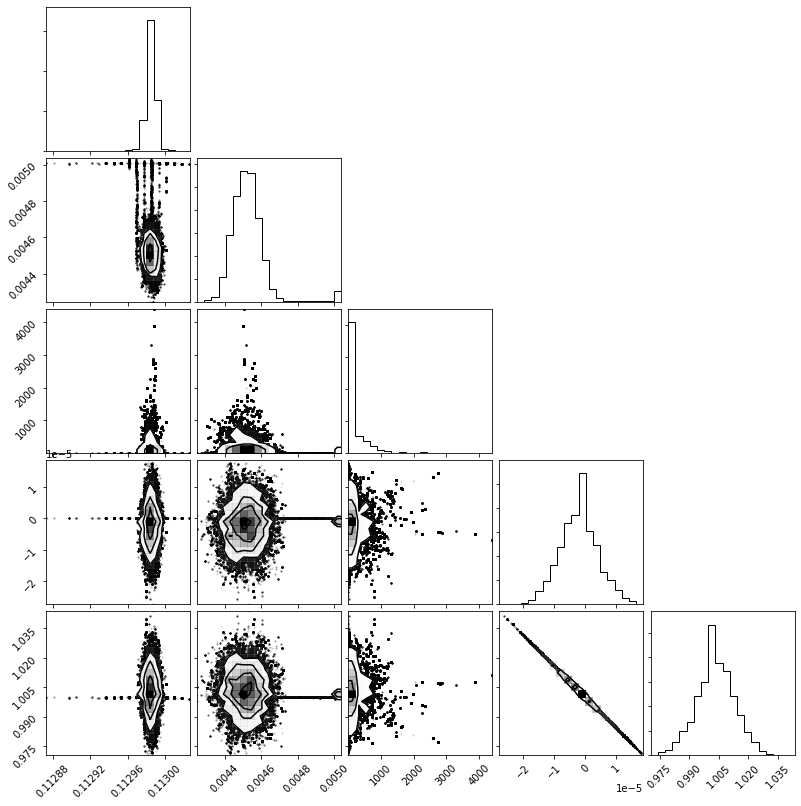

In [516]:
samples = sampler.get_chain(discard=0,flat=True)
fig = corner.corner(samples)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
#plt.hist(samples.T[0], bins=np.linspace(0,.2, 300));

In [517]:
samples.T[0].shape
np.median(samples.T[0])

0.11298529266296879

In [518]:
result = []
for i in range(5):
    result.append(np.percentile(samples.T[i],[.16,.5,.84]))

In [519]:
result

[array([0.11296136, 0.11296148, 0.1129695 ]),
 array([0.00431643, 0.00434303, 0.00435952]),
 array([0.06545102, 0.22509778, 0.34936657]),
 array([-2.01628071e-05, -1.73841954e-05, -1.61731825e-05]),
 array([0.97662268, 0.97762274, 0.97948012])]

In [513]:
result

[array([0.11293715, 0.11295334, 0.1129614 ]),
 array([0.00431315, 0.00433775, 0.00434945]),
 array([0.02835132, 0.07168193, 0.15015211]),
 array([-2.01628071e-05, -1.79336972e-05, -1.67035019e-05]),
 array([0.97804528, 0.9809813 , 0.98306463])]

In [464]:
model = cosine(time, result[1][1], 2.*np.pi/result[0][1], result[2][1],result[3][1],result[4][1])
# model = cosine(time, inits[1]*.5, 2.*np.pi/inits[0], 2.*np.pi/8.5, 0., inits[4])

(1580.0, 1582.0)

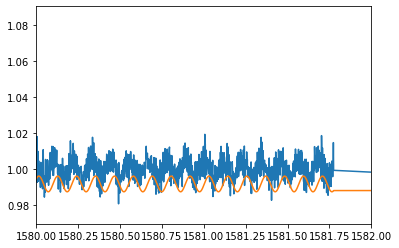

In [470]:
plt.plot(time, flux)
plt.plot(time, model)
plt.xlim(1592,1594)
plt.xlim(1580,1582)

In [404]:
501 * 2. / 60.

16.7